In [10]:
from transformers import AutoProcessor , AutoModelForCausalLM
from PIL import Image
import requests
import copy
%matplotlib inline

In [12]:
import torch

if torch.cuda.is_available():
    print(torch.version.cuda)
else:
    print("CUDA is not available")

12.4


In [16]:
model_id = 'microsoft/Florence-2-large'
model= AutoModelForCausalLM.from_pretrained(model_id,trust_remote_code=True).eval()
processor = AutoProcessor.from_pretrained(model_id,trust_remote_code=True)

In [18]:
print(model)
print(processor)


Florence2ForConditionalGeneration(
  (vision_tower): DaViT(
    (convs): ModuleList(
      (0): ConvEmbed(
        (proj): Conv2d(3, 256, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (1): ConvEmbed(
        (proj): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (2): ConvEmbed(
        (proj): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (3): ConvEmbed(
        (proj): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
    (blocks): ModuleList(
      (0): MySequential(
        (0): MySequential(
          (spatial_block): SpatialBlock(
            (conv1): PreNorm(
              (fn): De

In [20]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )
    return parsed_answer

In [22]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)


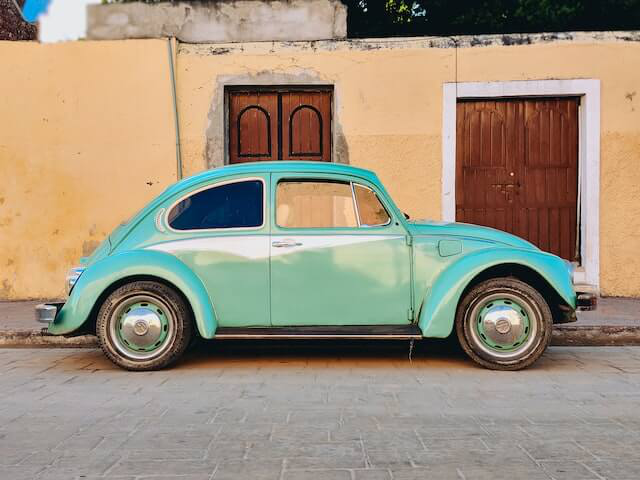

In [24]:
image

In [28]:
task_prompt = '<CAPTION>'
run_example(task_prompt)

{'<CAPTION>': 'A green car parked in front of a yellow building.'}

In [32]:
task_prompt = '<DETAILED_CAPTION>'
run_example(task_prompt)

{'<DETAILED_CAPTION>': 'The image shows a blue Volkswagen Beetle parked in front of a yellow building with two brown doors, surrounded by trees and a clear blue sky.'}

In [34]:
task_prompt = '<MORE_DETAILED_CAPTION>'
run_example(task_prompt)

{'<MORE_DETAILED_CAPTION>': 'The image shows a vintage Volkswagen Beetle car parked on a cobblestone street in front of a yellow building with two wooden doors. The car is painted in a bright turquoise color and has a sleek, streamlined design. It has two doors on either side of the car, one on top of the other, and a small window on the front. The building appears to be old and dilapidated, with peeling paint and crumbling walls. The sky is blue and there are trees in the background.'}

In [36]:
task_prompt = '<OD>'
results=run_example(task_prompt)
print(results)

{'<OD>': {'bboxes': [[33.599998474121094, 159.59999084472656, 596.7999877929688, 371.7599792480469], [454.0799865722656, 96.23999786376953, 580.7999877929688, 261.8399963378906], [224.95999145507812, 86.15999603271484, 333.7599792480469, 164.39999389648438], [449.5999755859375, 276.239990234375, 554.5599975585938, 370.3199768066406], [91.19999694824219, 280.0799865722656, 198.0800018310547, 370.3199768066406]], 'labels': ['car', 'door', 'door', 'wheel', 'wheel']}}


In [38]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_bbox(image, data):
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):

        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox

        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')

        # Add the rectangle to the Axes
        ax.add_patch(rect)

        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()


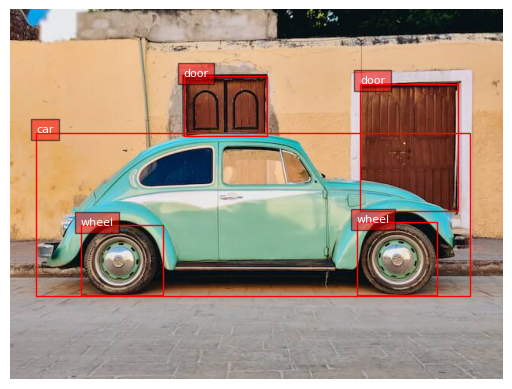

In [40]:
plot_bbox(image, results['<OD>'])


In [46]:
task_prompt = '<DENSE_REGION_CAPTION>'
results=run_example(task_prompt)
print(results)

{'<DENSE_REGION_CAPTION>': {'bboxes': [[33.599998474121094, 159.59999084472656, 596.7999877929688, 371.7599792480469], [454.0799865722656, 96.72000122070312, 580.1599731445312, 261.8399963378906], [449.5999755859375, 276.239990234375, 554.5599975585938, 370.79998779296875], [91.83999633789062, 280.0799865722656, 198.0800018310547, 370.79998779296875], [224.95999145507812, 86.15999603271484, 333.7599792480469, 164.39999389648438]], 'labels': ['turquoise Volkswagen Beetle', 'wooden double doors with metal handles', 'wheel', 'wheel', 'door']}}


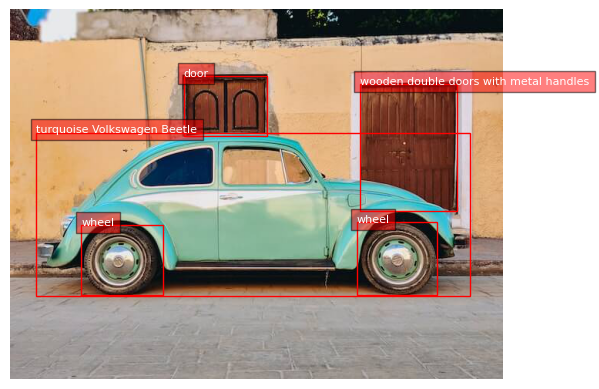

In [48]:
plot_bbox(image, results['<DENSE_REGION_CAPTION>'])


In [50]:
task_prompt = '<REGION_PROPOSAL>'
results=run_example(task_prompt)
print(results)

{'<REGION_PROPOSAL>': {'bboxes': [[33.599998474121094, 159.59999084472656, 596.7999877929688, 371.7599792480469], [454.0799865722656, 96.23999786376953, 580.7999877929688, 261.8399963378906], [449.5999755859375, 276.239990234375, 554.5599975585938, 370.3199768066406], [91.19999694824219, 280.0799865722656, 198.0800018310547, 370.3199768066406], [224.3199920654297, 85.19999694824219, 333.7599792480469, 164.39999389648438], [274.239990234375, 178.8000030517578, 392.0, 228.239990234375], [165.44000244140625, 178.8000030517578, 264.6399841308594, 230.63999938964844]], 'labels': ['', '', '', '', '', '', '']}}


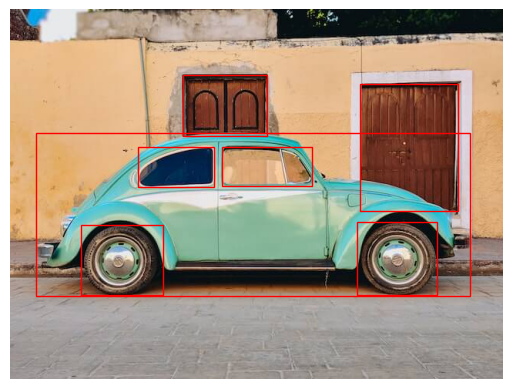

In [51]:
plot_bbox(image, results['<REGION_PROPOSAL>'])


In [2]:
import onnx

print(onnx.__version__)

ImportError: DLL load failed while importing onnx_cpp2py_export: A dynamic link library (DLL) initialization routine failed.